In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv('daily_prices_sentiment_num_tweets_1.1.22_3.31.23.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,mean_weighted_sentiment,num_tweets
0,1/1/2022,46311.74609,47827.31250,46288.48438,47686.81250,47686.81250,2.458267e+10,0.100179,13259
1,1/2/2022,47680.92578,47881.40625,46856.93750,47345.21875,47345.21875,2.795157e+10,0.076259,14544
2,1/3/2022,47343.54297,47510.72656,45835.96484,46458.11719,46458.11719,3.307163e+10,0.075941,22219
3,1/4/2022,46458.85156,47406.54688,45752.46484,45897.57422,45897.57422,4.249468e+10,0.074601,18951
4,1/5/2022,45899.35938,46929.04688,42798.22266,43569.00391,43569.00391,3.685108e+10,0.060661,23294


In [3]:
# ditch all columns except for Date, Close, mean_weighted_sentiment, num_tweets
df = df.loc[:, ['Date', 'Close', 'mean_weighted_sentiment', 'num_tweets']]
df.head()

,Date,Close,mean_weighted_sentiment,num_tweets
0,1/1/2022,47686.81250,0.100179,13259
1,1/2/2022,47345.21875,0.076259,14544
2,1/3/2022,46458.11719,0.075941,22219
3,1/4/2022,45897.57422,0.074601,18951
4,1/5/2022,43569.00391,0.060661,23294


Just Exploring the Data

In [ ]:
df.dtypes

Date                        object
Close                      float64
mean_weighted_sentiment    float64
num_tweets                   int64
dtype: object

In [ ]:
df.describe()

,Close,mean_weighted_sentiment,num_tweets
count,455.000000,455.000000,455.000000
mean,27145.282448,0.073689,26489.683516
std,9473.987966,0.025649,10187.200352
min,15787.284180,0.006723,13259.000000
25%,19822.229490,0.057521,20707.000000
50%,23078.728520,0.072575,23805.000000
75%,37225.585935,0.089505,26930.000000
max,47686.812500,0.164712,78451.000000


Sentiment and Number of Tweets over Time: the number of tweets goes up significantly when the sentiment decreases

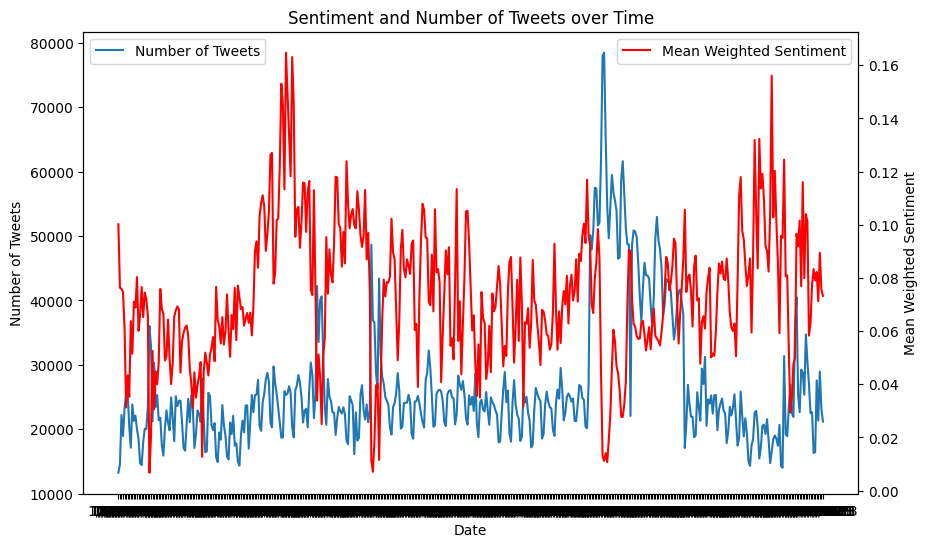

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()

ax1.plot(df['Date'], df['num_tweets'], label='Number of Tweets')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Tweets')

ax2.plot(df['Date'], df['mean_weighted_sentiment'], label='Mean Weighted Sentiment', color='red')
ax2.set_ylabel('Mean Weighted Sentiment')

plt.title('Sentiment and Number of Tweets over Time')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

Sentiment and Price over Time: not sure what to really say about this but here it is

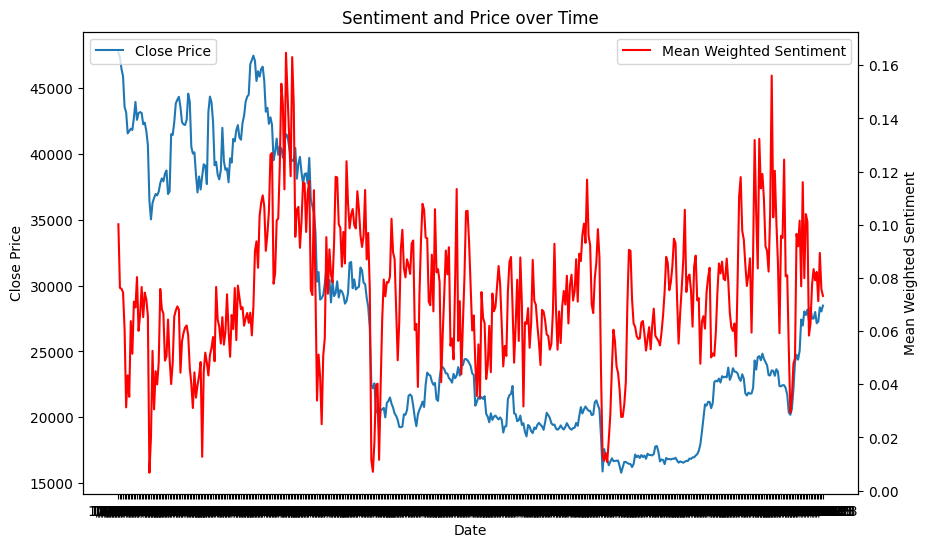

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()

ax1.plot(df['Date'], df['Close'], label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price')

ax2.plot(df['Date'], df['mean_weighted_sentiment'], label='Mean Weighted Sentiment', color='red')
ax2.set_ylabel('Mean Weighted Sentiment')

plt.title('Sentiment and Price over Time')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

Number of Tweets and Price over Time: the number of tweets also seems to increase significantly with the closing price going down dramatically

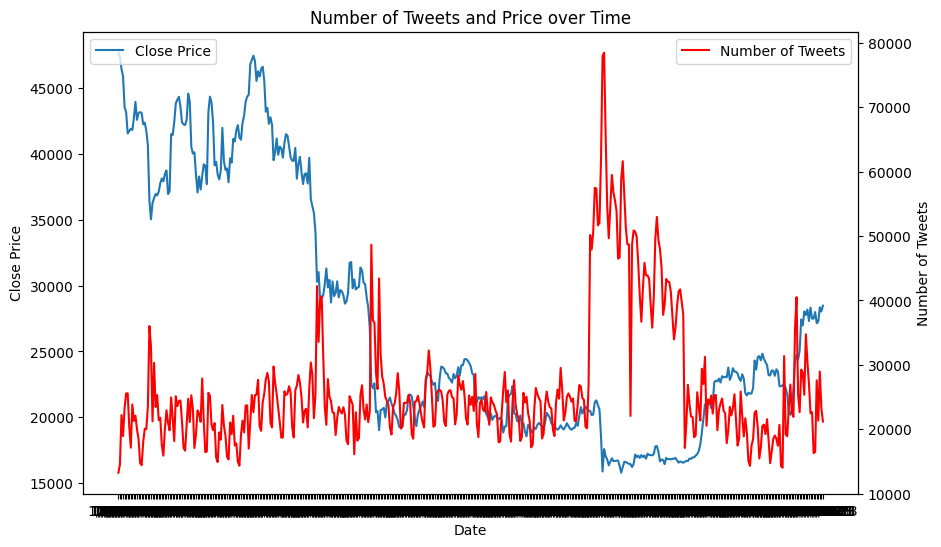

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()

ax1.plot(df['Date'], df['Close'], label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price')

ax2.plot(df['Date'], df['num_tweets'], label='Number of Tweets', color='red')
ax2.set_xlabel('Date')
ax2.set_ylabel('Number of Tweets')

plt.title('Number of Tweets and Price over Time')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [4]:
# set date column as the index of the dataframe
df.set_index('Date', inplace=True)
df.head()

,Close,mean_weighted_sentiment,num_tweets
Date,,,
1/1/2022,47686.81250,0.100179,13259
1/2/2022,47345.21875,0.076259,14544
1/3/2022,46458.11719,0.075941,22219
1/4/2022,45897.57422,0.074601,18951
1/5/2022,43569.00391,0.060661,23294


In [5]:
def df_to_day_window_and_split_label_col(df, window_size):
    df_as_np = df.to_numpy()
    X = [] # window size length of previous days columns to use to predict
    y = [] # label to predict
    for i in range(len(df_as_np) - window_size): # length less than window size to avoid out of bounds since getting window size length of previous days
        row = [r for r in df_as_np[i: i + window_size]] # get all of the current rows data up through the next rows for the length of the window size into 1 row
        X.append(row)
        label = df_as_np[i + window_size][0] # index 0 is the close price column 
        y.append(label)
    
    return np.array(X), np.array(y)

In [6]:
# explored WINDOW_SIZE in the range of 1-15, and NUM_ATTRIBUTES (Close, mean_weighted_sentiment, num_tweets), (Close, mean_weighted_sentiment), (Close)
WINDOW_SIZE = 3
NUM_ATTRIBUTES = 2
NUM_EPOCHS = 100

In [7]:
# normalize each column creating new df_norm dataframe and adding columns to original dataframe for reference
df_norm = (
    (df[['Close', 'mean_weighted_sentiment', 'num_tweets']] - df[['Close', 'mean_weighted_sentiment', 'num_tweets']].min()) 
    / (df[['Close', 'mean_weighted_sentiment', 'num_tweets']].max() - df[['Close', 'mean_weighted_sentiment', 'num_tweets']].min())
)

# adding the normalized columns to original dataframe for reference
df[['Close_norm', 'mean_weighted_sentiment_norm', 'num_tweets_norm']] = df_norm

df.head()

,Close,mean_weighted_sentiment,num_tweets,Close_norm,mean_weighted_sentiment_norm,num_tweets_norm
Date,,,,,,
1/1/2022,47686.81250,0.100179,13259,1.000000,0.591538,0.000000
1/2/2022,47345.21875,0.076259,14544,0.989292,0.440132,0.019711
1/3/2022,46458.11719,0.075941,22219,0.961482,0.438118,0.137440
1/4/2022,45897.57422,0.074601,18951,0.943910,0.429640,0.087311
1/5/2022,43569.00391,0.060661,23294,0.870913,0.341407,0.153930


In [ ]:
df_norm.head()

,Close,mean_weighted_sentiment,num_tweets
Date,,,
1/1/2022,1.000000,0.591538,0.000000
1/2/2022,0.989292,0.440132,0.019711
1/3/2022,0.961482,0.438118,0.137440
1/4/2022,0.943910,0.429640,0.087311
1/5/2022,0.870913,0.341407,0.153930


In [8]:
# experimenting with dropping num_tweets or mean_weighted_sentiment 
df_norm = df_norm.drop('num_tweets', axis=1)
# df_norm = df_norm.drop('mean_weighted_sentiment', axis=1)

In [ ]:
df_norm.head()

,Close,mean_weighted_sentiment
Date,,
1/1/2022,1.000000,0.591538
1/2/2022,0.989292,0.440132
1/3/2022,0.961482,0.438118
1/4/2022,0.943910,0.429640
1/5/2022,0.870913,0.341407


In [9]:
X, y = df_to_day_window_and_split_label_col(df_norm, window_size=WINDOW_SIZE)

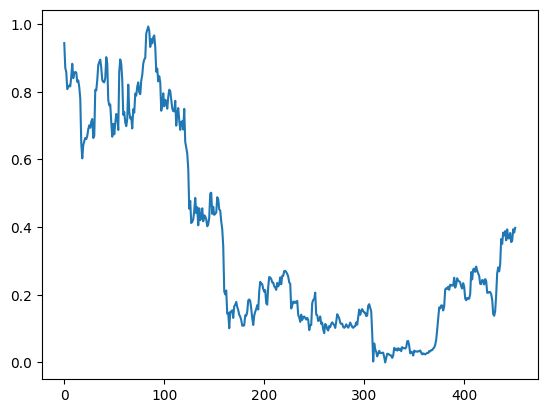

In [ ]:
plt.plot(y)

In [10]:
# splitting data into 60% training, 20% validation, 20% testing sets 
num_train_samples = math.floor(0.60 * len(X))
print(num_train_samples)
num_validation_samples = math.floor(0.2 * len(X))
print(num_validation_samples)
num_test_samples = len(X) - num_train_samples - num_validation_samples
print(num_test_samples)
val_samples_high_range = num_train_samples + num_validation_samples

X_train, y_train = X[:num_train_samples], y[:num_train_samples]
X_val, y_val = X[num_train_samples:val_samples_high_range], y[num_train_samples:val_samples_high_range]
X_test, y_test = X[val_samples_high_range:], y[val_samples_high_range:]

271
90
91


In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape) 

(271, 3, 2)
(271,)
(90, 3, 2)
(90,)
(91, 3, 2)
(91,)


LSTM sequential model of a linear stack of layers. </br>The input layer shape is the LSTM window size and the number of attribute columns used. </br>The next layer is an LSTM recurrent neural network layer with 64 memory units. </br>A Dense layer is then added with a Rectified Linear Unit (ReLU) activation function with 8 fully connected neurons in order to map the higher-dimensional output of the previous layer to a lower-dimensional representation. </br>The final Dense output layer is then added with a linear activation function and a single neuron to output the actual predicted price for the day

In [ ]:
model_1 = Sequential()
model_1.add(InputLayer((WINDOW_SIZE, NUM_ATTRIBUTES))) 
model_1.add(LSTM(64))
model_1.add(Dense(8, 'relu'))
model_1.add(Dense(1, 'linear'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17152     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,681
Trainable params: 17,681
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp_1 = ModelCheckpoint('model1/', save_best_only=True) # save best weights in model1, ModelCheckpoint keeps track of the best weights as each epoch is run
model_1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model_1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=NUM_EPOCHS, callbacks=[cp_1])

Epoch 1/100
1/9 [==>...........................] - ETA: 26s - loss: 0.3914 - root_mean_squared_error: 0.6256

9/9 [==============================] - 9s 667ms/step - loss: 0.3903 - root_mean_squared_error: 0.6248 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0992
Epoch 2/100
1/9 [==>...........................] - ETA: 0s - loss: 0.3593 - root_mean_squared_error: 0.5995

9/9 [==============================] - 5s 658ms/step - loss: 0.3734 - root_mean_squared_error: 0.6110 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0929
Epoch 3/100
8/9 [=========================>....] - ETA: 0s - loss: 0.3556 - root_mean_squared_error: 0.5964

9/9 [==============================] - 5s 643ms/step - loss: 0.3556 - root_mean_squared_error: 0.5964 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0893
Epoch 4/100
1/9 [==>...........................] - ETA: 0s - loss: 0.3101 - root_mean_squared_error: 0.5569

9/9 [==============================] - 5s 637ms/step - loss: 0.3385 - root_mean_squared_error: 0.5818 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0865
Epoch 5/100
1/9 [==>...........................] - ETA: 0s - loss: 0.3416 - root_mean_squared_error: 0.5845

9/9 [==============================] - 5s 665ms/step - loss: 0.3218 - root_mean_squared_error: 0.5672 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0833
Epoch 6/100
1/9 [==>...........................] - ETA: 0s - loss: 0.2819 - root_mean_squared_error: 0.5309

9/9 [==============================] - 5s 645ms/step - loss: 0.3070 - root_mean_squared_error: 0.5540 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0785
Epoch 7/100
1/9 [==>...........................] - ETA: 0s - loss: 0.4240 - root_mean_squared_error: 0.6511

9/9 [==============================] - 5s 627ms/step - loss: 0.2952 - root_mean_squared_error: 0.5433 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0737
Epoch 8/100
8/9 [=========================>....] - ETA: 0s - loss: 0.2910 - root_mean_squared_error: 0.5395

9/9 [==============================] - 5s 616ms/step - loss: 0.2852 - root_mean_squared_error: 0.5341 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0692
Epoch 9/100
1/9 [==>...........................] - ETA: 0s - loss: 0.2529 - root_mean_squared_error: 0.5029

9/9 [==============================] - 5s 654ms/step - loss: 0.2760 - root_mean_squared_error: 0.5253 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0649
Epoch 10/100
1/9 [==>...........................] - ETA: 0s - loss: 0.2136 - root_mean_squared_error: 0.4622

9/9 [==============================] - 5s 679ms/step - loss: 0.2673 - root_mean_squared_error: 0.5170 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0608
Epoch 11/100
1/9 [==>...........................] - ETA: 0s - loss: 0.2226 - root_mean_squared_error: 0.4718

9/9 [==============================] - 5s 640ms/step - loss: 0.2583 - root_mean_squared_error: 0.5082 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0571
Epoch 12/100
1/9 [==>...........................] - ETA: 0s - loss: 0.2886 - root_mean_squared_error: 0.5372

9/9 [==============================] - 5s 642ms/step - loss: 0.2497 - root_mean_squared_error: 0.4997 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0535
Epoch 13/100
9/9 [==============================] - ETA: 0s - loss: 0.2408 - root_mean_squared_error: 0.4908

9/9 [==============================] - 5s 663ms/step - loss: 0.2408 - root_mean_squared_error: 0.4908 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0504
Epoch 14/100
1/9 [==>...........................] - ETA: 0s - loss: 0.1859 - root_mean_squared_error: 0.4311

9/9 [==============================] - 5s 564ms/step - loss: 0.2323 - root_mean_squared_error: 0.4819 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0478
Epoch 15/100
1/9 [==>...........................] - ETA: 0s - loss: 0.3041 - root_mean_squared_error: 0.5515

9/9 [==============================] - 6s 744ms/step - loss: 0.2237 - root_mean_squared_error: 0.4730 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0457
Epoch 16/100
1/9 [==>...........................] - ETA: 0s - loss: 0.2353 - root_mean_squared_error: 0.4850

9/9 [==============================] - 5s 618ms/step - loss: 0.2151 - root_mean_squared_error: 0.4638 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0444
Epoch 17/100
1/9 [==>...........................] - ETA: 0s - loss: 0.2682 - root_mean_squared_error: 0.5179

9/9 [==============================] - 6s 732ms/step - loss: 0.2066 - root_mean_squared_error: 0.4545 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 18/100
9/9 [==============================] - 0s 12ms/step - loss: 0.1981 - root_mean_squared_error: 0.4451 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0441
Epoch 19/100
9/9 [==============================] - 0s 12ms/step - loss: 0.1895 - root_mean_squared_error: 0.4353 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0452
Epoch 20/100
9/9 [==============================] - 0s 12ms/step - loss: 0.1811 - root_mean_squared_error: 0.4256 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0472
Epoch 21/100
9/9 [==============================] - 0s 13ms/step - loss: 0.1727 - root_mean_squared_error: 0.4156 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0500
Epoch 22/100
9/9 [==============================] - 0s 11ms/step - loss: 0.1643 - root_mean_squared_error: 0.4053 - val_loss: 0.0029 - val_root_mean_squared_

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

def plot_predictions(model, X, y):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'], label='Predictions')
    plt.plot(df['Actuals'], label='Actuals')

    plt.title('Daily Price Predictions')
    plt.xlabel('Days')
    plt.ylabel('Price')

    plt.legend()
    mean_sq_err = mse(y, predictions)
    mean_abs_err = mae(y, predictions)
    root_mean_sq_err = np.sqrt(mse(y, predictions))
    r2 = r2_score(y, predictions)
    return df, mean_sq_err, mean_abs_err, root_mean_sq_err, r2

3/3 [==============================] - 1s 5ms/step


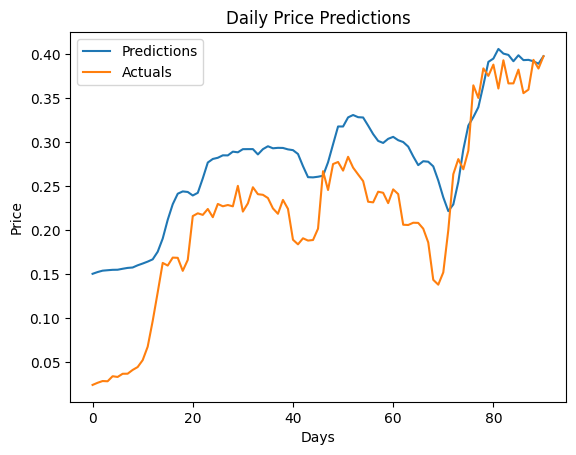

In [ ]:
# make predictions on test set with model and return accuracy metrics
_, mean_sq_err, mean_abs_error, root_mean_sq_err, r2 = plot_predictions(model_1, X_test, y_test)

In [ ]:
print(f'mean squared error: {mean_sq_err}')
print(f'root mean squared error: {root_mean_sq_err}')
print(f'mean absolute error: {mean_abs_error}')
print(f'R2 score: {r2}')

mean squared error: 0.004975336225369415
root mean squared error: 0.07053606329651106
mean absolute error: 0.061647431045211254
R2 score: 0.4817983902342152


In [ ]:
def plot_predictions_unnormalized(model, X, y, y_min, y_max):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions': predictions, 'Actuals': y})

    # Unnormalize predictions and actuals
    predictions = predictions * (y_max - y_min) + y_min
    actuals = y * (y_max - y_min) + y_min

    plt.plot(predictions, label='Predictions')
    plt.plot(actuals, label='Actuals')
    plt.legend()

    plt.xlabel('Day')
    plt.ylabel('Bitcoin Close Price ($)')

    mean_sq_err = mse(actuals, predictions)
    mean_abs_err = mae(actuals, predictions)
    root_mean_sq_err = np.sqrt(mean_sq_err)
    r2 = r2_score(actuals, predictions)

    return df, mean_sq_err, mean_abs_err, root_mean_sq_err, r2

In [ ]:
print(df['Close'].min())
print(df['Close'].max())

15787.28418
47686.8125


3/3 [==============================] - 0s 4ms/step


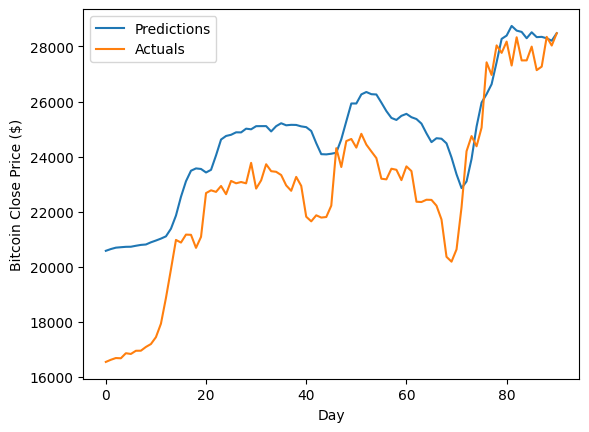

In [ ]:
_, mean_sq_err, mean_abs_error, root_mean_sq_err, r2 = plot_predictions_unnormalized(model_1, X_test, y_test, df['Close'].min(), df['Close'].max())

In [ ]:
print(f'mean squared error: {mean_sq_err}')
print(f'root mean squared error: {root_mean_sq_err}')
print(f'mean absolute error: {mean_abs_error}')
print(f'R2 score: {r2}')

mean squared error: 5062801.488575938
root mean squared error: 2250.066996463869
mean absolute error: 1966.5237805975273
R2 score: 0.4817984603595368


In [ ]:
# MSE = NMSE * (max(actuals) - min(actuals))^2
# unnormalizing specific Mean Squared Error values
def unnormalize_accuracy_metrics(mse, rmse, mae, y_min, y_max):
    unnormalized_mse = mse * (y_max - y_min) ** 2
    unnormalized_rmse = np.sqrt(unnormalized_mse)
    unnormalized_mae = mae * (y_max - y_min) 

    return (unnormalized_mse, unnormalized_rmse, unnormalized_mae)

In [ ]:
unnormalized_mse, unnormalized_rmse, unnormalized_mae = unnormalize_accuracy_metrics(0.003510284, 0.054645427, 0.047023078, df['Close'].min(), df['Close'].max())
print(f'unnormalized_mse: {unnormalized_mse}')
print(f'unnormalized_rmse: {unnormalized_rmse}')
print(f'unnormalized_mae: {unnormalized_mae}')

unnormalized_mse: 3571994.46639867
unnormalized_rmse: 1889.9720808516379
unnormalized_mae: 1500.014008354569
